Load the C. Elegans connectome. Downloaded from https://wormwiring.org/series/. Exported from chemicalmatrix.xlsx.

In [1]:
using LinearAlgebra;
using Test;

using CSV;
using DataFrames;
using DataFramesMeta;
using Plots;

using DataStructures;

gr()

table = CSV.read("chemicalmatrix_posterior.csv") |> DataFrame;
typeof(table)

DataFrame

Clean up the table.

In [2]:
# Rename columns
rename!(table, Dict(:Column2 => :group, 
                    :Column3 => :subgroup,
                    :Column4 => :neuron))
cols = [:group, :subgroup]

# Fill NA's with preceding values
lastvalid = Dict()
for col in cols
    lastvalid[col] = missing
end

for row in eachrow(table)
    for col in cols
        if row[col] === missing
            row[col] = lastvalid[col]
        else
            lastvalid[col] = row[col]
        end
    end
end

In [3]:
pre_neurons = table[5:size(table, 1) - 1, :neuron]
post_neurons = Vector(table[4, 5:length(pre_neurons) + 4]);
@assert post_neurons == pre_neurons

meta = table[5:size(table, 1) - 1, [:neuron, :group, :subgroup]]
connection_strength = table[5:size(table, 1) - 1, 5:length(pre_neurons) + 4]
@assert size(connection_strength, 1) == size(connection_strength, 2)

In [4]:
#names(connection_strength)[1]
#convert(Array{Union{Int, Missing}}, connection_strength.PHAL)
# Rename columns.
names!(connection_strength, Symbol.(post_neurons))

# Replace NA
for col in names(connection_strength)
    connection_strength[ismissing.(connection_strength[:, col]), col] = "0"
end

# Finally, obtain the data frame of the connection strengths.
df_C_T = parse.(Int, connection_strength);

┌ Warning: implicit broadcasting in setindex! is deprecated; use `df[row_inds, col_ind] .= Ref(v)` broadcasting assignment to change the column in place
│   caller = setindex!(::DataFrame, ::String, ::BitArray{1}, ::Symbol) at deprecated.jl:1490
└ @ DataFrames /home/pmin/.julia/packages/DataFrames/XuYBH/src/deprecated.jl:1490


Create a connection strength matrix the long way, by iterating through the dataframe.

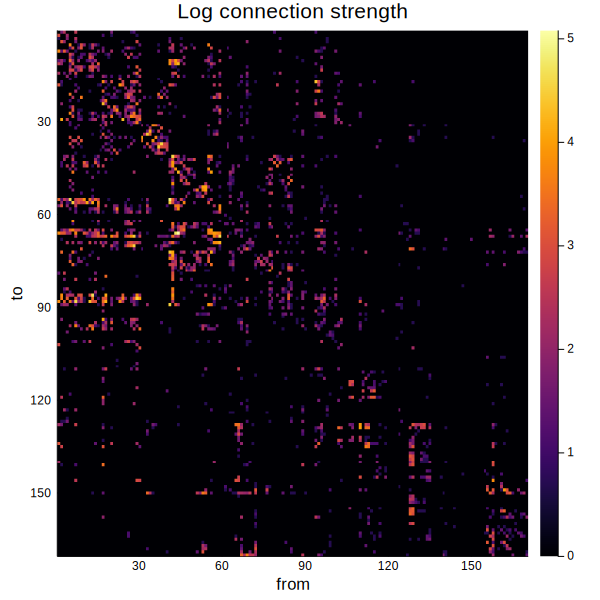

In [5]:
heatmap(transpose(log1p.(convert(Matrix, df_C_T))), size=(600, 600), yflip=:true)
title!("Log connection strength")
xlabel!("from")
ylabel!("to")

Look at how symmetric the weight matrix is.

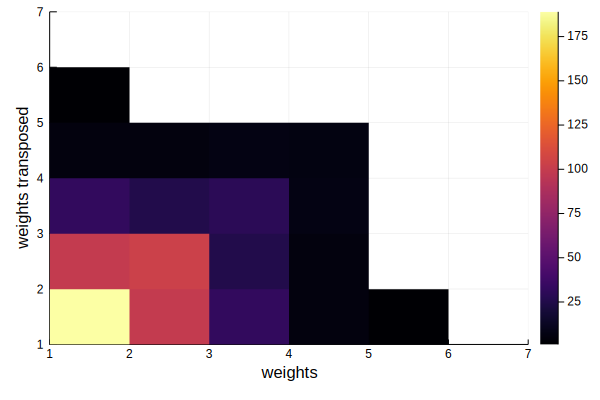

In [6]:
C_T = convert(Matrix, df_C_T)
C = transpose(C_T)
C_ = reshape(transpose(C_T), length(C_T))
C_T_ = reshape(C_T, length(C_T));

histogram2d(log1p.(C_), log1p.(C_T_), bins=1:7)
xlabel!("weights")
ylabel!("weights transposed")

In [7]:
using Statistics;

good_idx = (C_ .!= 0) .& (C_T_ .!= 0)
cor(hcat(C_[good_idx], C_T_[good_idx]))
#sum(good_idx)

2×2 Array{Float64,2}:
 1.0       0.266513
 0.266513  1.0     

The weight matrix is not very symmetric.

# Find hubs in the data using PageRank

Do this using the non-binarized connection matrix.

In [8]:
alpha = .85
total_degree = sum(C, dims=1)
total_degree[total_degree .== 0] .= 1

Lambda = (C ./ (reshape(total_degree, (1, length(total_degree)))))

# Make sure that we've normalized properly.

# If we've normalized properly, it follows that for every node, the sum of the out nodes is 1.0
# i.e. sum(Lambda[:, i]) == 1 \forall i (unless it's equal to 0 because there are no outgoing nodes)
sums = sum(Lambda, dims=1);
@assert all(isapprox.(sums, 1.0) .| isapprox.(sums, 0.0))

x_star = sum(inv(I - alpha * Lambda), dims=2);

In [9]:
#annotategroups(meta)

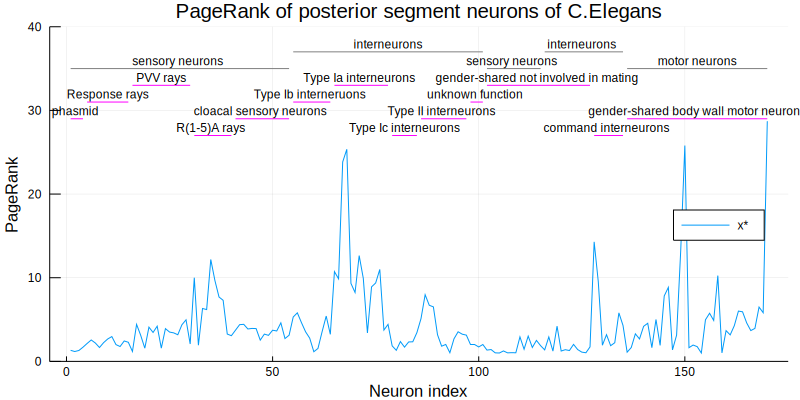

In [51]:
function annotategroups!(meta, ypos=0)
    # Join similar metadata groups together
    group = missing
    subgroup = missing
    
    groups = []
    subgroups = []
    
    group_start = 1
    subgroup_start = 1
    for (i, row) in enumerate(eachrow(meta))
        if group !== row.group
            if i > 1
                push!(groups, (group, group_start, i - 1))
            end
            group_start = i
        end
        group = row.group
        
        if subgroup !== row.subgroup
            if i > 1
                push!(subgroups, (subgroup, subgroup_start, i - 1))
            end
            subgroup_start = i
        end
        subgroup = row.subgroup
    end
    
    push!(groups, (group, group_start, size(meta, 1)))
    push!(subgroups, (subgroup, subgroup_start, size(meta, 1)))
    
    i = 1
    heights = 4
    dh = 2
    for (name, s, e) in subgroups
        annotate!([((s + e) ÷ 2, 
                    ypos + (i % heights) * dh + .2, 
                    text(name, 8, :blue, :center, :bottom))])
        plot!([s, e], 
            [ypos + (i % heights) * dh, 
             ypos + (i % heights) * dh], c=:magenta, label="")
        i += 1
    end
    
    for (name, s, e) in groups
        annotate!([((s + e) ÷ 2, 
                    ypos + ((i % 2) + heights) * dh + .2, 
                    text(name, 8, :blue, :center, :bottom))])
        plot!([s, e], 
            [ypos + ((i % 2) + heights) * dh, 
             ypos + ((i % 2) + heights) * dh], c=:gray, label="")
        i += 1
    end
    
end

plot(x_star, size=(800, 400), legend=:right, label="x*");
ylims!((0, 40))
annotategroups!(meta, 27);
xlabel!("Neuron index")
ylabel!("PageRank")
title!("PageRank of posterior segment neurons of C.Elegans")

# Look at the network distance between neurons

Use Floyd's algorithm: https://www.cs.rochester.edu/u/nelson/courses/csc_173/graphs/apsp.html. It consists of iterations:

$$D_{ij} = \min_k (D_{ij}, D_{ik} + D_{kj})$$

Starting from D = the cost matrix.

In [11]:


N = size(D, 1)

for iter = 1:N
    D_old = copy(D)
    for i = 1:N
        for j = 1:N
            D[i, j] = min(D[i, j], minimum(D[i, :] .+ D[:, j]));
        end
    end
    
    if D_old == D
        # Stable.
        println("Converged in $iter iterations.")
        break
    end
end

Converged in 3 iterations.


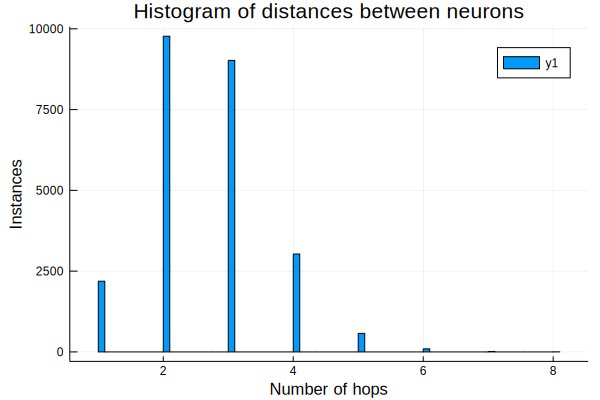

In [12]:
histogram(D[:])
title!("Histogram of distances between neurons")
xlabel!("Number of hops")
ylabel!("Instances")

Sanity check: only the matrix elements which have self-connections should have a "self-distance" of 1.

In [13]:
selfconnected = diag(C) .> 0
selfdistance = diag(D)

@assert (selfdistance .== 1) == selfconnected
@assert minimum(D[:]) == 1.0

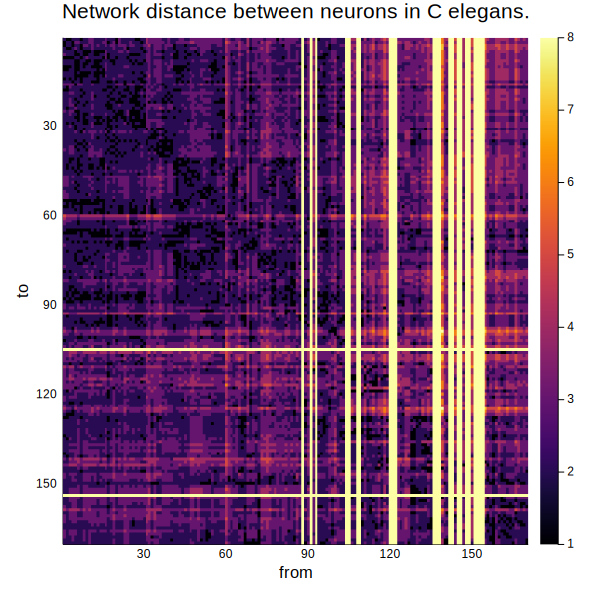

In [60]:
d = copy(D)
d[d .== Inf] .= 8;

heatmap(d, size=(600, 600), yflip=:true)
title!("Network distance between neurons in C elegans.")
xlabel!("from")
ylabel!("to")

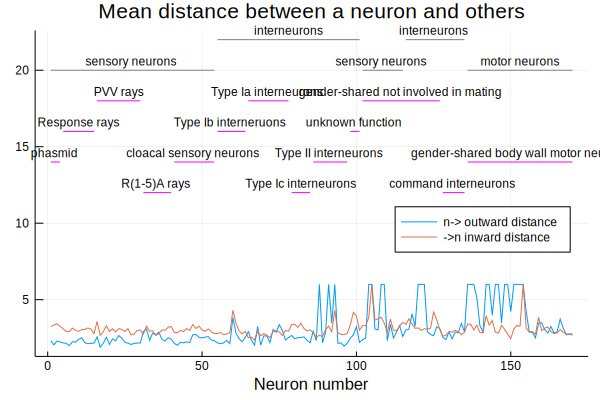

In [55]:
plot(mean(d, dims=1)[:], label="n-> outward distance", legend=:right)
plot!(mean(d, dims=2)[:], label="->n inward distance")

annotategroups!(meta, 12);
title!("Mean distance between a neuron and others")
xlabel!("Neuron number")

Naturally, the inward distance tends to be larger then the outward distance for sensory neurons (meaning that they're more source than sink). The opposite is true for motor neurons (they're mostly sinks for information). The distribution of outward projections looks more diverse than inward projections. Let's check that.

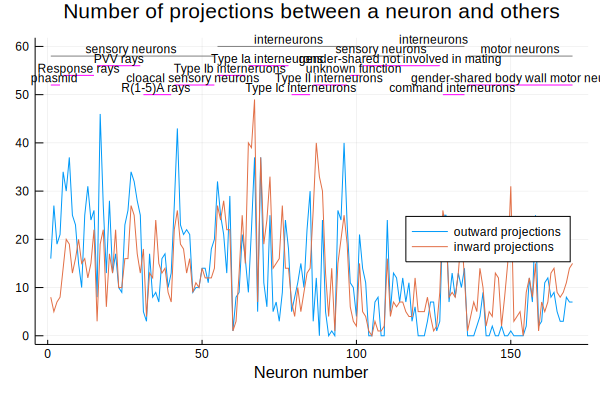

In [71]:
adjacency = 1 .*(C .>= 1)

plot(sum(adjacency, dims=1)[:], label="outward projections", legend=:right)
plot!(sum(adjacency, dims=2)[:], label="inward projections")

annotategroups!(meta, 50);
title!("Number of projections between a neuron and others")
xlabel!("Neuron number")

This generally seems to hold - but in addition, sensory neurons and interneurons seem to make more total connections (both inward and outward) than motor neurons. Motor neurons look more like true sinks, but sensory neurons receive connections from other sensory neurons and from interneurons.

# Look at the bowtie plot of the data

Split the data into IN, strongly connected, and out. Inspired by: https://www.cs.cornell.edu/home/kleinber/networks-book/networks-book-ch13.pdf

Start by finding the giant connected component.

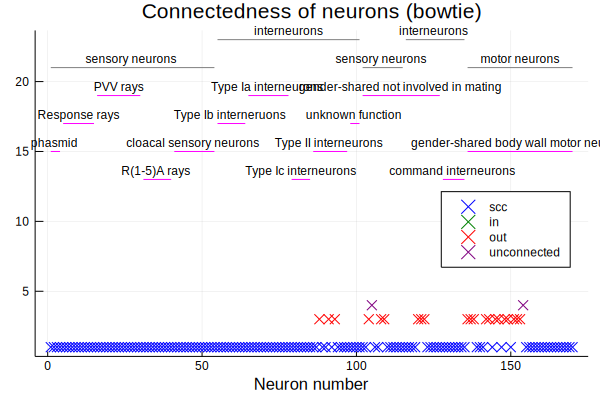

In [119]:
# Start by finding the giant SCC component.
idx = [1]
for next in range(2, stop=size(D, 1))
    probe = vcat(idx, [next])
    if all(D[probe, probe] .< Inf)
        push!(idx, next)
    end
end

scc = idx

# Now find the in and out components
idx = ones(size(D, 1))
idx[scc] .= 0

inc = Int64[]
outc = Int64[]

unconnected = findall(idx .== 1)
for i in unconnected
    if minimum(D[scc, i]) < Inf
        append!(inc, i)
    elseif minimum(D[i, scc]) < Inf
        append!(outc, i)
    end
end

# Now find the unconnected components
idx[inc] .= 0
idx[outc] .= 0

unc = findall(idx .== 1)

@assert minimum(D[:, unc]) == Inf
@assert minimum(D[unc, :]) == Inf

scatter(scc, ones(length(scc)), markerstrokecolor=:blue, markershape=:x, markerstrokewidth=1, label="scc", legend=:right)
scatter!(inc, 2*ones(length(inc)), markerstrokecolor=:green, markershape=:x, markerstrokewidth=1, label="in", legend=:right)
scatter!(outc, 3*ones(length(outc)), markerstrokecolor=:red, markershape=:x, markerstrokewidth=1, label="out", legend=:right)
scatter!(unc, 4*ones(length(unc)), markerstrokecolor=:purple, markershape=:x, markerstrokewidth=1, label="unconnected", legend=:right)

annotategroups!(meta, 13);
title!("Connectedness of neurons (bowtie)")
xlabel!("Neuron number")

In [ ]:
pus

# Find communities in the data

In [16]:
# TODO